Modified and verified by **Heejoon Moon**
- version: 11.28

## **0. Preprocessing Data**
- concat RGB frames and opticalflow
- transform videos to '.npy' format
  - '.npy' has 5 channels -> RGB (3) and opticalflow ((u, v) -> 2)
  - you can use another opticalflow algorithms

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def getOpticalFlow(video):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel]. dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img, (224, 224, 1)))

    flows = []
    for i in range(0, len(video) - 1):
        # calculate optical flow between each pair of frames
        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i + 1], None, 0.5, 3, 15, 3, 5, 1.2,
                                            cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])
        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)
        # Add into list
        flows.append(flow)

    # Padding the last frame as empty array
    flows.append(np.zeros((224, 224, 2)))

    return np.array(flows, dtype=np.float32)


def Video2Npy(file_path, resize=(224,224)):
    """Load video and tansfer it into .npy format
    Args:
        file_path: the path of video file
        resize: the target resolution of output video
    Returns:
        frames: gray-scale video
        flows: magnitude video of optical flows
    """
    # Load video
    cap = cv2.VideoCapture(file_path)
    # Get number of frames
    len_frames = int(cap.get(7))
    # Extract frames from video
    try:
        frames = []
        for i in range(len_frames-1):
            _, frame = cap.read()
            frame = cv2.resize(frame,resize, interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = np.reshape(frame, (224,224,3))
            frames.append(frame)
    except:
        print("Error: ", file_path, len_frames,i)
    finally:
        frames = np.array(frames)
        cap.release()

    # Get the optical flow of video
    flows = getOpticalFlow(frames)

    # Visualize optical flow map
    optical_flow_map = farneback_visual(flows, save_path="farneback_visualization.mp4")

    result = np.zeros((len(flows),224,224,5))
    result[...,:3] = frames
    result[...,3:] = flows

    return result

def farneback_visual(flows, save_path="farneback_optical_flow.mp4", fps=15):
    ##Visualize Farneback optical flow as a color-coded map and save as a video.

    # Define the video dimensions and writer
    h, w = flows.shape[1], flows.shape[2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(save_path, fourcc, fps, (w, h))

    # Process each frame
    for flow in flows:
        # Calculate magnitude and angle of 2D flow vectors
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # Create HSV image
        hsv = np.zeros((h, w, 3), dtype=np.uint8)
        hsv[..., 0] = (angle * 180 / np.pi / 2).astype(np.uint8)
        hsv[..., 1] = 255  # Saturation: Set to maximum
        hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Convert HSV to RGB for visualization
        rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        # Write the frame to the video file
        out.write(rgb_flow)

    # Release the video writer
    out.release()
    print(f"Optical flow visualization saved as '{save_path}'")




def Save2Npy(file_dir, save_dir):   # modify this code to save the npy files for your directory or path
    """Transfer all the videos and save them into specified directory
    Args:
        file_dir: source folder of target videos
        save_dir: destination folder of output .npy files
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    for v in tqdm(videos):
        # Split video name
        video_name = v.split('.')[0]
        # Get src
        video_path = os.path.join(file_dir, v)
        # Get dest
        save_path = os.path.join(save_dir, video_name+'.npy')
        # Load and preprocess video
        data = Video2Npy(file_path=video_path, resize=(224,224))
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path, data)

    return None

### convert data and save it (offline)

In [ ]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Computer Vision /Project/raw_video.zip'
extract_dir = '/content/drive/MyDrive/Computer Vision /Project/RWF-2000 Dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
source_path = '/content/drive/MyDrive/Computer Vision /Project/Dataset'
target_path = '/content/drive/MyDrive/Computer Vision /Project/npy_dataset'

for f1 in ['train', 'val']:
    for f2 in ['Fight', 'NonFight']:
        path1 = os.path.join(source_path, f1, f2)
        path2 = os.path.join(target_path, f1, f2)
        Save2Npy(file_dir=path1, save_dir=path2)

Processing frames:   0%|          | 0/149 [00:00<?, ?it/s]<ipython-input-1-b21fe839a697>:112: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)

Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.85it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.72it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.75it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.31it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.63it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.71it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.86it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  8.94it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.53it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.77it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.83it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.72it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.72it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.83it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.72it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.55it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.74it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.73it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.72it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.74it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.80it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.62it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.46it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.63it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.70it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.65it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.70it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.44it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.68it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.40it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:18<00:00,  8.13it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.48it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.70it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.45it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.23it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:18<00:00,  7.99it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.09it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.44it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:18<00:00,  7.96it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  8.84it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.41it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.67it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.53it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.61it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.51it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.43it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.38it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.56it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:15<00:00,  9.36it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.10it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.24it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.27it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.27it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.20it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  8.98it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:18<00:00,  8.27it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.08it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.03it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.21it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.24it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.18it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  8.99it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  8.82it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.75it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.06it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.17it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  8.89it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.04it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.10it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.64it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  8.87it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  8.95it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.43it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.49it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.67it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.46it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.50it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  9.03it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.35it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:18<00:00,  8.17it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:18<00:00,  8.06it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:16<00:00,  8.78it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.45it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.81it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:17<00:00,  8.34it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:18<00:00,  8.25it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:18<00:00,  8.14it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.72it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.78it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.76it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.69it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:18<00:00,  7.97it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:18<00:00,  7.93it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.63it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.52it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.54it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.69it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.64it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.59it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.65it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.66it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.58it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:21<00:00,  7.02it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.66it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:21<00:00,  7.06it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames: 100%|██████████| 149/149 [00:19<00:00,  7.67it/s]


Optical flow visualization saved as 'farneback_optical_flow.mp4'


Processing frames:  28%|██▊       | 41/149 [00:05<00:12,  8.36it/s]

In [ ]:
source_path = '/content/drive/MyDrive/Travail - Louis/A5 - Corée/Introduction to Computer Vision/Projet/RWF-2000 Dataset'
target_path = '/content/drive/MyDrive/Travail - Louis/A5 - Corée/Introduction to Computer Vision/Projet/npy_dataset'

for f1 in ['test']:
    for f2 in ['Fight', 'NonFight']:
        path1 = os.path.join(source_path, f1, f2)
        path2 = os.path.join(target_path, f1, f2)
        Save2Npy(file_dir=path1, save_dir=path2)

100%|██████████| 10/10 [00:39<00:00,  3.98s/it]


## **1. Build Data Loader**

In [ ]:
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2

class DataGenerator(Dataset):

    ### basic function templates for Dataset class in Pytorch : __init__, __len__, __getitem__###
    def __init__(self, directory, data_augmentation=True, phase='train'):
        self.phase=phase
        self.directory = directory
        self.data_aug = data_augmentation
        self.X_path, self.Y_dict = self.search_data()
        self.print_stats()

    def __len__(self):
        steps_per_epoch = int(len(self.X_path))
        return steps_per_epoch

    # get data and label corresponding to index using 'data_generation function'
    def __getitem__(self, index):
        data, label = self.data_generation(self.X_path[index])
        return data.float(), label

    #############################################################
    # -----------------codes down from this line are provided.------------------- #
    # call raw data using data path, and data processing including 'uniform sampling', 'color jittering', 'random flip', and 'normalize'
    #############################################################

    def load_data(self, path):
        data = np.load(path, mmap_mode='r') # Read the raw data from path
        data = self.uniform_sampling(data, target_frames=64) # Randomly sample number of target frames
        if self.data_aug: # If data is augmented...
            data[..., :3] = self.color_jitter(data[..., :3])
            data = self.random_flip(data, prob=0.5) # Random flip image into random direction
        data[..., :3] = self.normalize(data[..., :3]) # Normalize RGB
        data[..., 3:] = self.normalize(data[..., 3:]) # Normalize optical flows
        return data

    # shuffle data
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # Normalize data
    def normalize(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(video, (2,)) # Flip in width direction
        return video

    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])
        # calculate numer of padded frames and fix it
        num_pad = target_frames - len(sampled_video) # num pad = # target frame - # current frame
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try:
                    padding.append(video[i]) # Fill with the last video frame
                except:
                    padding.append(video[0])
            sampled_video += padding # Add padding results
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)

    # Jitter = spread values
    def color_jitter(self, video):
        s_jitter = np.random.uniform(-0.2, 0.2)
        v_jitter = np.random.uniform(-30, 30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(np.array(video[i]), cv2.COLOR_RGB2HSV) # Convert RGB -> HSV
            s = hsv[..., 1] + s_jitter # saturation jitter
            v = hsv[..., 2] + v_jitter # Value jitter
            # Flip
            s[s < 0] = 0
            s[s > 1] = 1
            v[v < 0] = 0
            v[v > 255] = 255
            hsv[..., 1] = s # set jittered saturation
            hsv[..., 2] = v # Set jittered value
            video[i] = torch.Tensor(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)) # Convert HSV -> RGB again
        return video

    # print current state sof the Dataset class
    def print_stats(self):
            self.n_files = len(self.X_path)
            self.n_classes = len(self.dirs)
            self.indexes = np.arange(len(self.X_path))
            np.random.shuffle(self.indexes)
            print("Found {} files belonging to {} classes.".format(self.n_files, self.n_classes))
            for i, label in enumerate(self.dirs):
                print('{:10s} : {}'.format(label, i))

    #############################################################
    # Fill the missing part of the code with functions given above
    #############################################################

    # get data and label(one-hot encoded) from path list/dictionary
    def search_data(self):
        X_path = []
        Y_dict = {}
        self.dirs = sorted(os.listdir(self.directory)) # Get sorted file directories
        one_hots = np.eye(len(self.dirs)) # One-hot encoded vector np_utils.to_categorical(range(len(self.dirs)))
        for i, folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory, folder)  # folder_path = ...train/Fight or ...train/NonFight
            for file in os.listdir(folder_path):
                # Add file path into X_path
                # Assign one hot encoded vector into Y_dict
                file_path = os.path.join(folder_path, file)
                X_path.append(file_path)
                Y_dict[file_path] = one_hots[i]
        return X_path, Y_dict

    # define batch x using 'load_data' function and batch_y from self.Y_dict.
    def data_generation(self, batch_path):
        batch_x = np.array(self.load_data(batch_path))
        batch_y = np.array(self.Y_dict[batch_path])

        # Transfer numpy array to tensor
        batch_x = torch.from_numpy(batch_x)
        batch_y = torch.from_numpy(batch_y)

        return batch_x, batch_y

## **2. Build Simple Model**
- this model is 'Flow Gated Network' proposed in 'RWF2000'
- you can use off-the-shelf architectures such as ResNet, EfficientNet, etc.
- model structure is produced in below image
- Fully-Connected layer is little bit different with image, so we provide Fully-Connected layer structure


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.relu=nn.ReLU(inplace=True)

        ## Hint: Please refer to above table for constructing layers
        # Construct block of RGB layers which takes RGB channel(3) as input
        self.rgb_block = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),

            nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),

            nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )

        # Construct block of optical flow layers which takes the optical flow channel(2) as input
        self.opt_block = nn.Sequential(
            nn.Conv3d(2, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),

            nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),

            nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )

        # Construct merging Block
        self.merge_block = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),

            nn.Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),

            nn.Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 3, 3))
        )

        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)

        # Initialize weights
        self.__init_weight()

    def forward(self, x):
        x = x.transpose(2,4)
        x = x.transpose(3,4)
        x = x.transpose(1,2)
        rgb = x[:,:3,:,:,:]
        opt = x[:,3:5,:,:,:]

        # Pass through the RGB data through the blocks of RGB layers
        rgb = self.rgb_block(rgb)
        # Pass through the optical flow data through the blocks of RGB layers
        opt = self.opt_block(opt)
        # Fuse by performing elementwise multiplication of rgb and opt tensors.
        fused = rgb * opt
        # Perform maxpooling of fused
        fused = nn.MaxPool3d(kernel_size=(8, 1, 1))(fused)

        # Pass through the fused data into merging block
        merged = self.merge_block(fused)

        # Fully Connected Layers
        x = merged.view(merged.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                # Perform weight initialization ("kaiming normal")
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

## **3. Training the Model**
- set hyper-parameters for training

In [ ]:
!pip install wandb

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import wandb
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define model, optimizer and criterion
model = FusionModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-6, nesterov=True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)
loss_fn = nn.CrossEntropyLoss()

trainset_path = '/content/drive/MyDrive/Computer Vision /Project/npy_dataset/train'
validation_path = '/content/drive/MyDrive/Computer Vision /Project/npy_dataset/val'

# define dataset and dataloader
train_dataset = DataGenerator(directory=trainset_path, data_augmentation=True)
val_dataset = DataGenerator(directory=validation_path, data_augmentation=False)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0)

# epoch = 30
# learning rate = 0.003

# optimizer = SGD
# weight decay = 1e-6
# momentum = 0.9
# nesterov = True
# gamma = 0.7

# loss = CrossEntropy

# assign device cpu or gpu
min_loss = np.inf


Found 160 files belonging to 2 classes.
Fight      : 0
NonFight   : 1
Found 40 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


In [ ]:
def _train(model, train_loader, loss_fn, optimizer):
    model.train()
    acc_temp = 0
    running_loss = 0

    # forward propagation and backpropagation
    # calculate accuracy and loss on training set
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = loss_fn(output, torch.max(target, 1)[1])

        loss.backward()
        optimizer.step()
        if target.ndim > 1:  # Check if target is one-hot encoded
          target = target.argmax(dim=1)
        running_loss += loss.item()
        pred = output.argmax(dim=1)
        acc_temp += (pred == target).sum().item()
    scheduler.step()

    train_acc = acc_temp / len(train_loader.dataset)
    train_loss = running_loss / len(train_loader.dataset)

    return train_acc, train_loss

In [ ]:
def _val(model, val_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        running_loss_val = 0
        acc_temp_val =0

        # calculate accuracy and loss on validation set
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, torch.max(target, 1)[1])
            if target.ndim > 1:  # Check if target is one-hot encoded
                target = target.argmax(dim=1)
            running_loss_val += loss.item()
            pred = output.argmax(dim=1)
            acc_temp_val += (pred == target).sum().item()

        val_acc = acc_temp_val / len(val_loader.dataset)
        val_loss = running_loss_val / len(val_loader.dataset)

    return val_acc, val_loss

In [ ]:
import random
import numpy as np

epoch=30
seed=0
random.seed(seed)
np.random.seed(seed)
device='cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if device =='cuda':
    print('gpu device is using')
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

wandb.login()
wandb.init(project='computer vision', name='RWF2000')

for epoch in range(epoch):
    # Perform training and validation
    train_acc, train_loss = _train(model, train_loader, loss_fn, optimizer)
    val_acc, val_loss = _val(model, val_loader, loss_fn)
    # Save the weights
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Computer Vision /Project/ModelsL/FusionModel_{}.pth'.format(epoch))
    # Log the training and validation results
    wandb.log({'train_acc': train_acc, 'train_loss': train_loss, 'val_acc': val_acc, 'val_loss': val_loss})

gpu device is using


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: e-nouadje1237 (e-nouadje). Use `wandb login --relogin` to force relogin


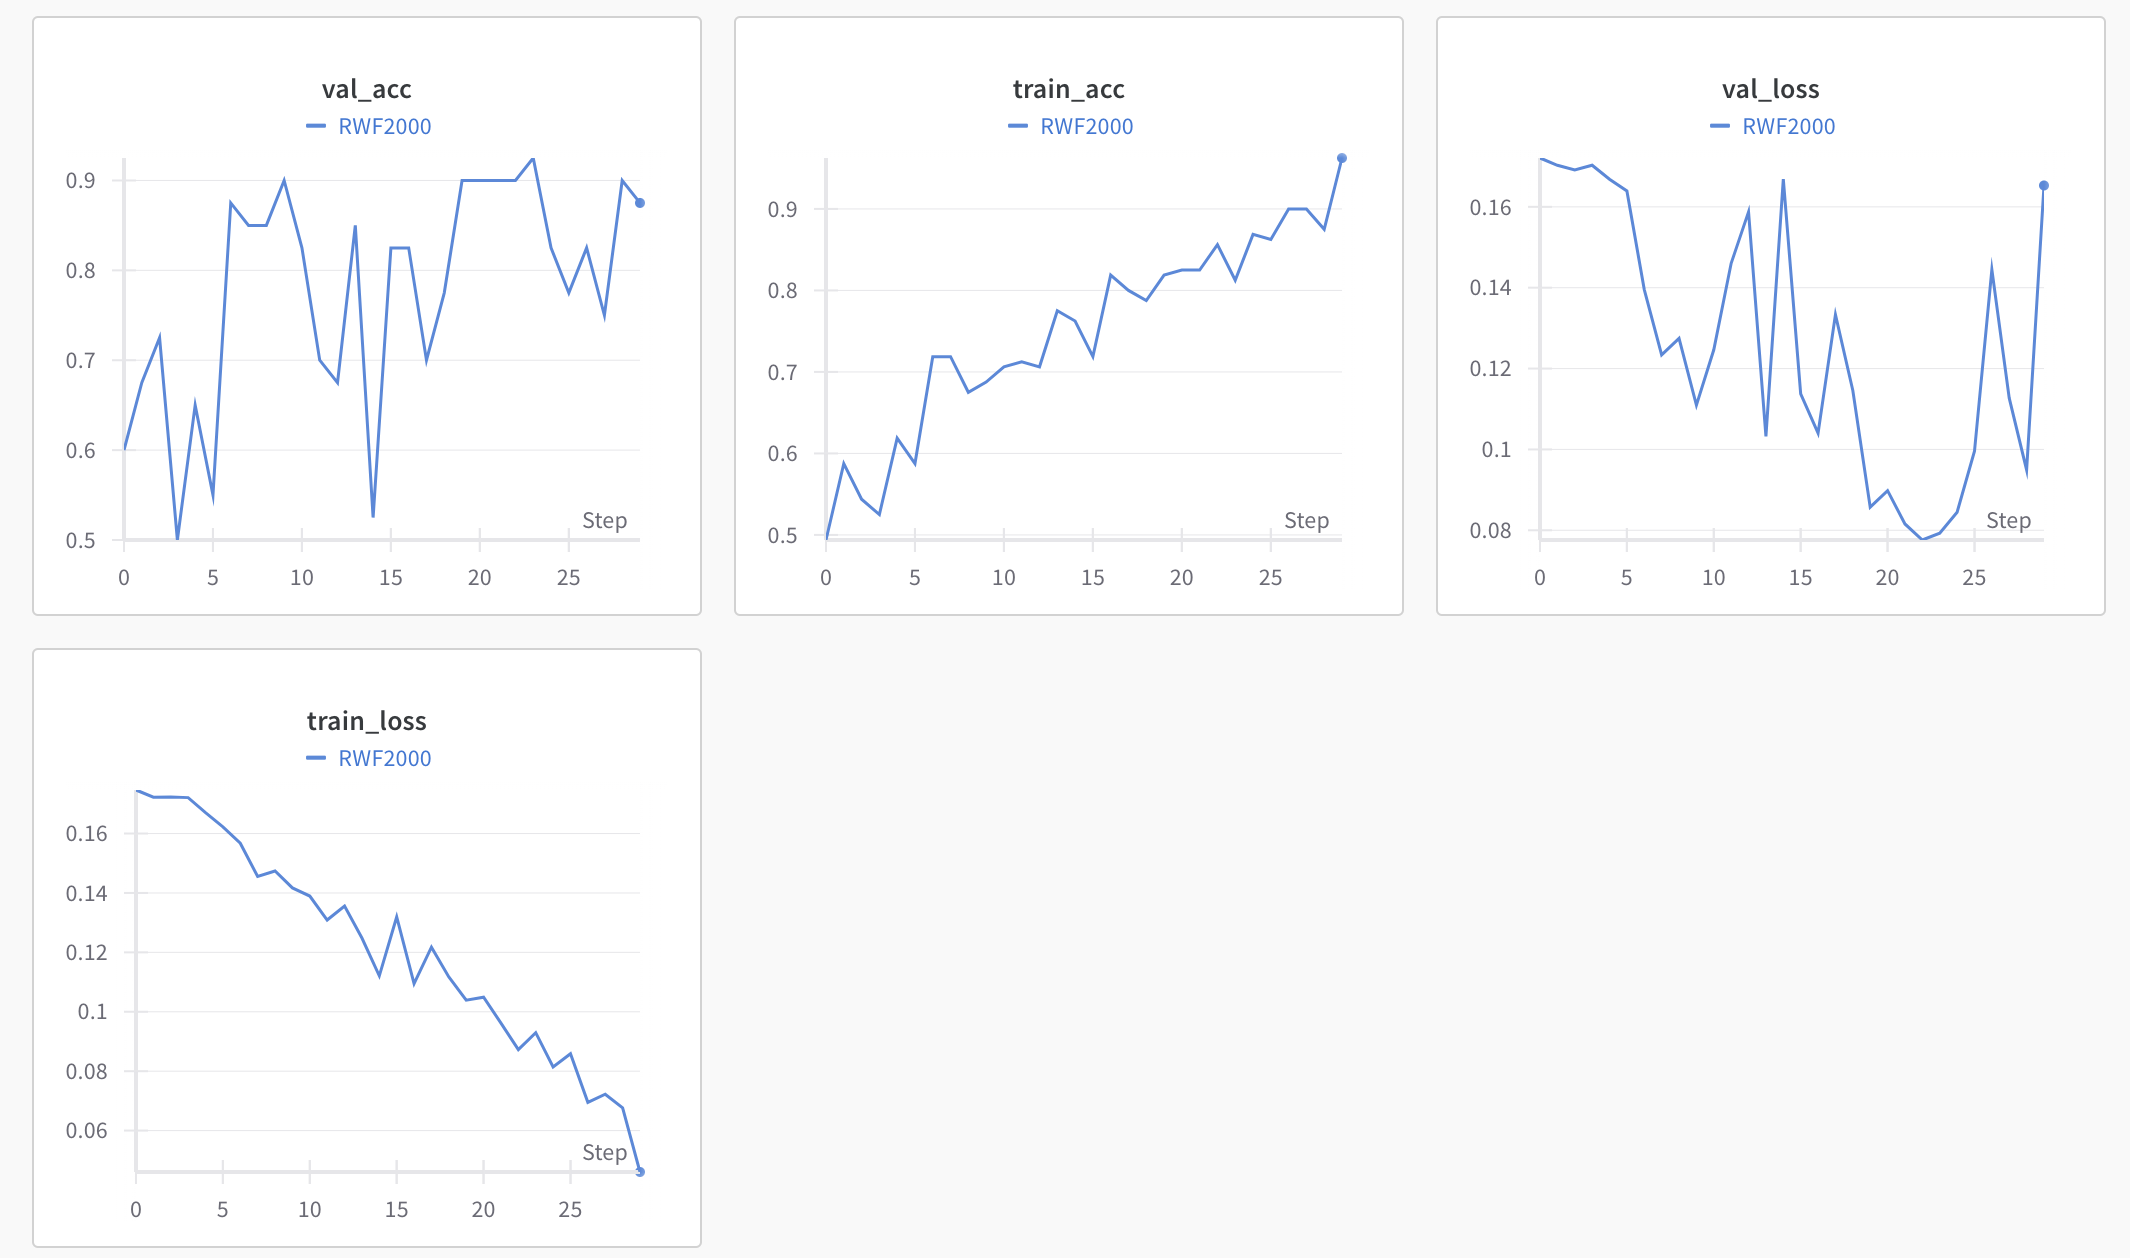

In [ ]:
best_model = '/content/drive/MyDrive/Computer Vision /Project/ModelsL/FusionModel_22.pth'
test_path = '/content/drive/MyDrive/Computer Vision /Project/npy_dataset/test'

test_dataset = DataGenerator(directory=test_path, data_augmentation=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

Found 20 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


<ipython-input-14-439c98c550ef>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model))



Test Accuracy: 0.85

AUROC: 0.85


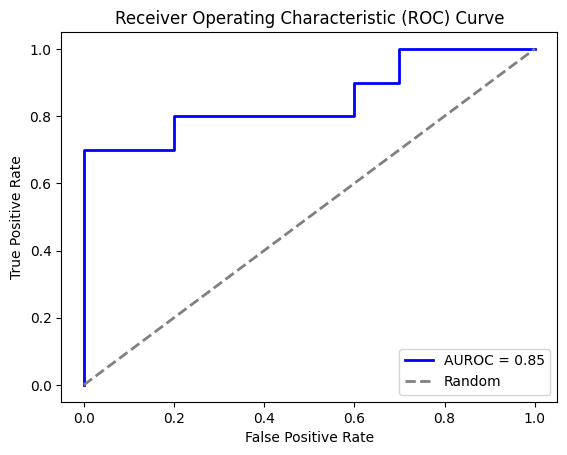

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model.load_state_dict(torch.load(best_model))
model.eval()
with torch.no_grad():
    # calculate accuracy and AUROC on test set
    acc_temp_test = 0
    y_true = []
    y_pred = []

    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        if target.ndim > 1:  # Check if target is one-hot encoded
            target = target.argmax(dim=1)
        acc_temp_test += (pred == target).sum().item()

        y_true.extend(target.cpu().numpy())
        y_pred.extend(output[:, 1].cpu().numpy())

    test_acc = acc_temp_test / len(test_loader.dataset)
    # print accuracy
    # print(y_true)
    print(f"\nTest Accuracy: {test_acc:.2f}")
    # y_true = np.argmax(y_true, axis=1)
    auroc = roc_auc_score(y_true, y_pred)
    print(f"\nAUROC: {auroc:.2f}")
    # plot AUROCa
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, label='Random', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()